In [34]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import scipy.io as sio


%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

In [35]:
df =  pd.read_csv("data_2/GHL/train.csv")
df.head()

,Time,RT_level_ini,RT_temperature.T,HT_temperature.T,RT_level,out_valve_act,dT_rand,inv_valve_act,limiter.y,inj_valve_act,Relaxing.active,boundary.m_flow_in,dir_valve_act,dt_rand,C_level,C_temperature.T,heater_act,HT_level,limiter1.y,dL_rand
0,0.0,0.0,283.149994,283.149994,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
1,1.0,0.0,283.149994,283.163330,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
2,2.0,0.0,283.149994,283.176666,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
3,3.0,0.0,283.149994,283.189972,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0
4,4.0,0.0,283.149994,283.203247,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0


In [36]:
rows_with_zero_or_nan = df.applymap(lambda x: pd.isna(x) ).any(axis=1)  # adding this not changing anything 'or x == 0'
count = rows_with_zero_or_nan.sum()
print(f"Number of rows with at least one 0 or NaN value: {count}")

/tmp/ipykernel_30697/2342891805.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rows_with_zero_or_nan = df.applymap(lambda x: pd.isna(x) ).any(axis=1)  # adding this not changing anything 'or x == 0'


Number of rows with at least one 0 or NaN value: 0


In [37]:
print(df.isnull().sum())

Time                  0
RT_level_ini          0
RT_temperature.T      0
HT_temperature.T      0
RT_level              0
out_valve_act         0
dT_rand               0
inv_valve_act         0
limiter.y             0
inj_valve_act         0
Relaxing.active       0
boundary.m_flow_in    0
dir_valve_act         0
dt_rand               0
C_level               0
C_temperature.T       0
heater_act            0
HT_level              0
limiter1.y            0
dL_rand               0
dtype: int64


In [38]:
# Convert timestamp to datetime
df['Time'] = pd.to_datetime(df['Time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1535118 entries, 0 to 1535117
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   Time                1535118 non-null  datetime64[ns]
 1   RT_level_ini        1535118 non-null  float64       
 2   RT_temperature.T    1535118 non-null  float64       
 3   HT_temperature.T    1535118 non-null  float64       
 4   RT_level            1535118 non-null  float64       
 5   out_valve_act       1535118 non-null  float64       
 6   dT_rand             1535118 non-null  float64       
 7   inv_valve_act       1535118 non-null  float64       
 8   limiter.y           1535118 non-null  float64       
 9   inj_valve_act       1535118 non-null  float64       
 10  Relaxing.active     1535118 non-null  float64       
 11  boundary.m_flow_in  1535118 non-null  float64       
 12  dir_valve_act       1535118 non-null  float64       
 13  dt_rand     

In [39]:
# Scale sensor data using StandardScaler
df_1 = df.drop(columns='Time')
sensor_cols = df_1.columns
scaler = MinMaxScaler()
df_1 = pd.DataFrame(scaler.fit_transform(df_1), columns=sensor_cols)

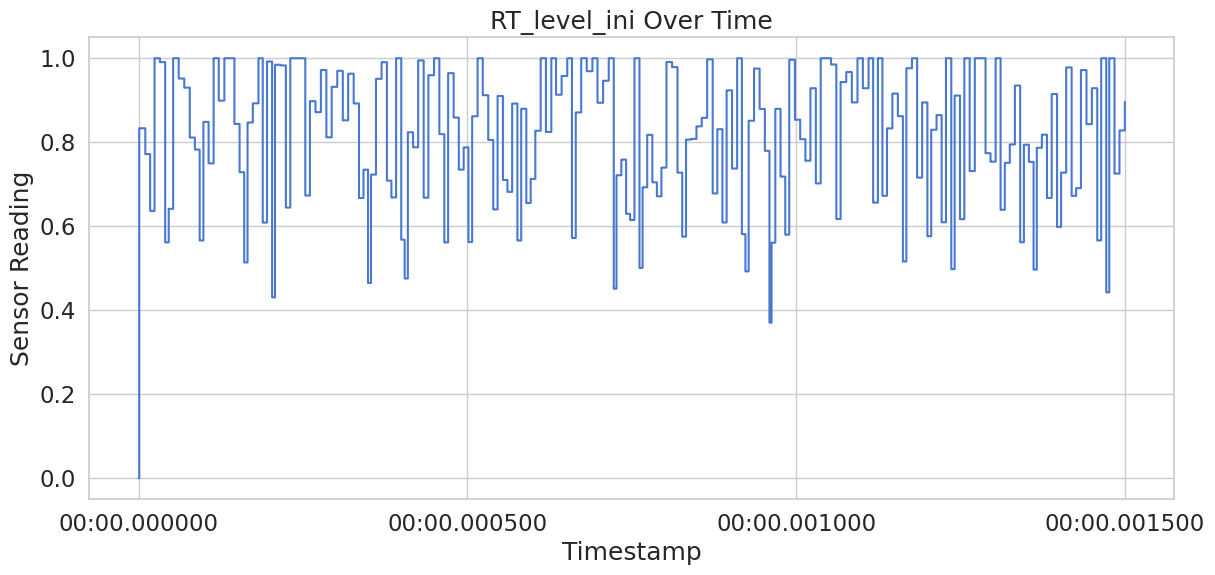

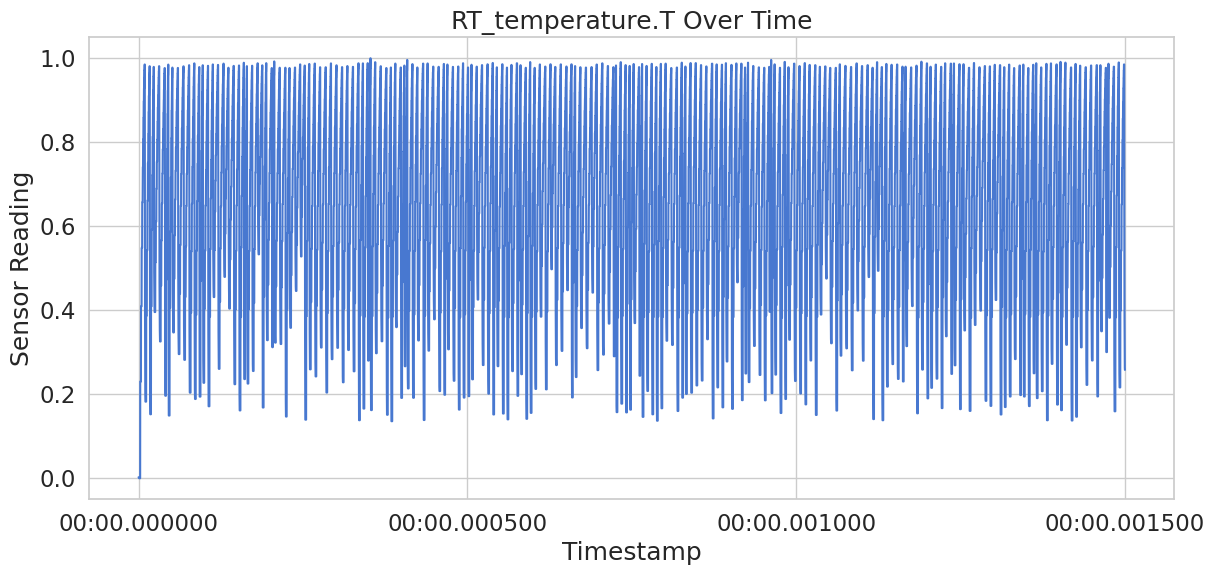

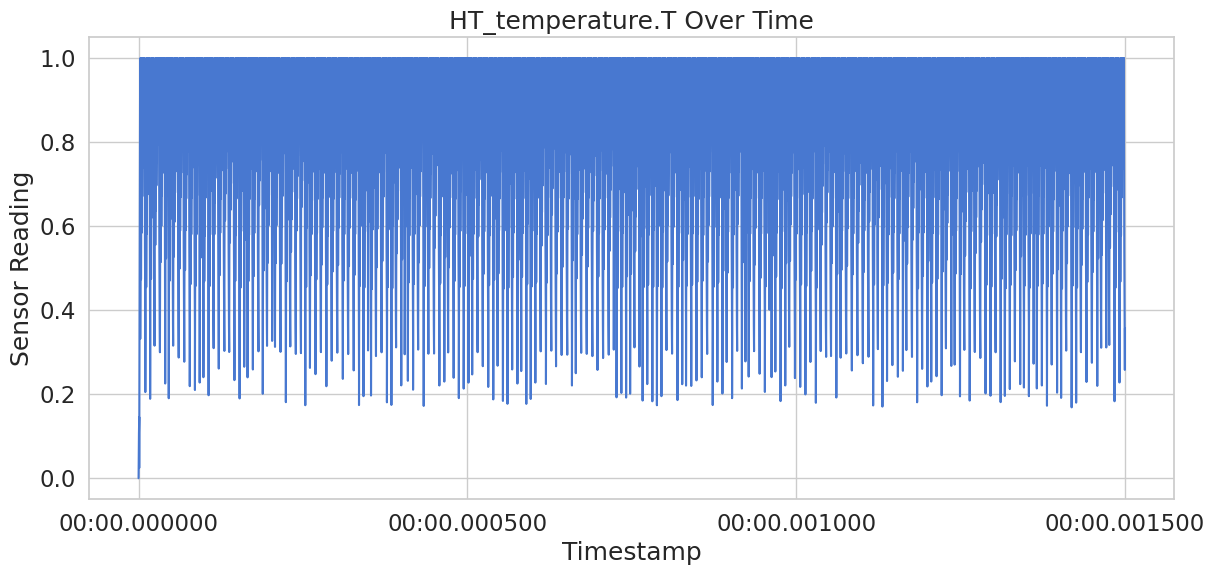

In [40]:
for col in sensor_cols[:3]:
    plt.figure(figsize=(14, 6))
    plt.plot(df['Time'], df_1[col])  # Ora df_1[col] funziona correttamente
    plt.title(f'{col} Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Reading')
    plt.show()

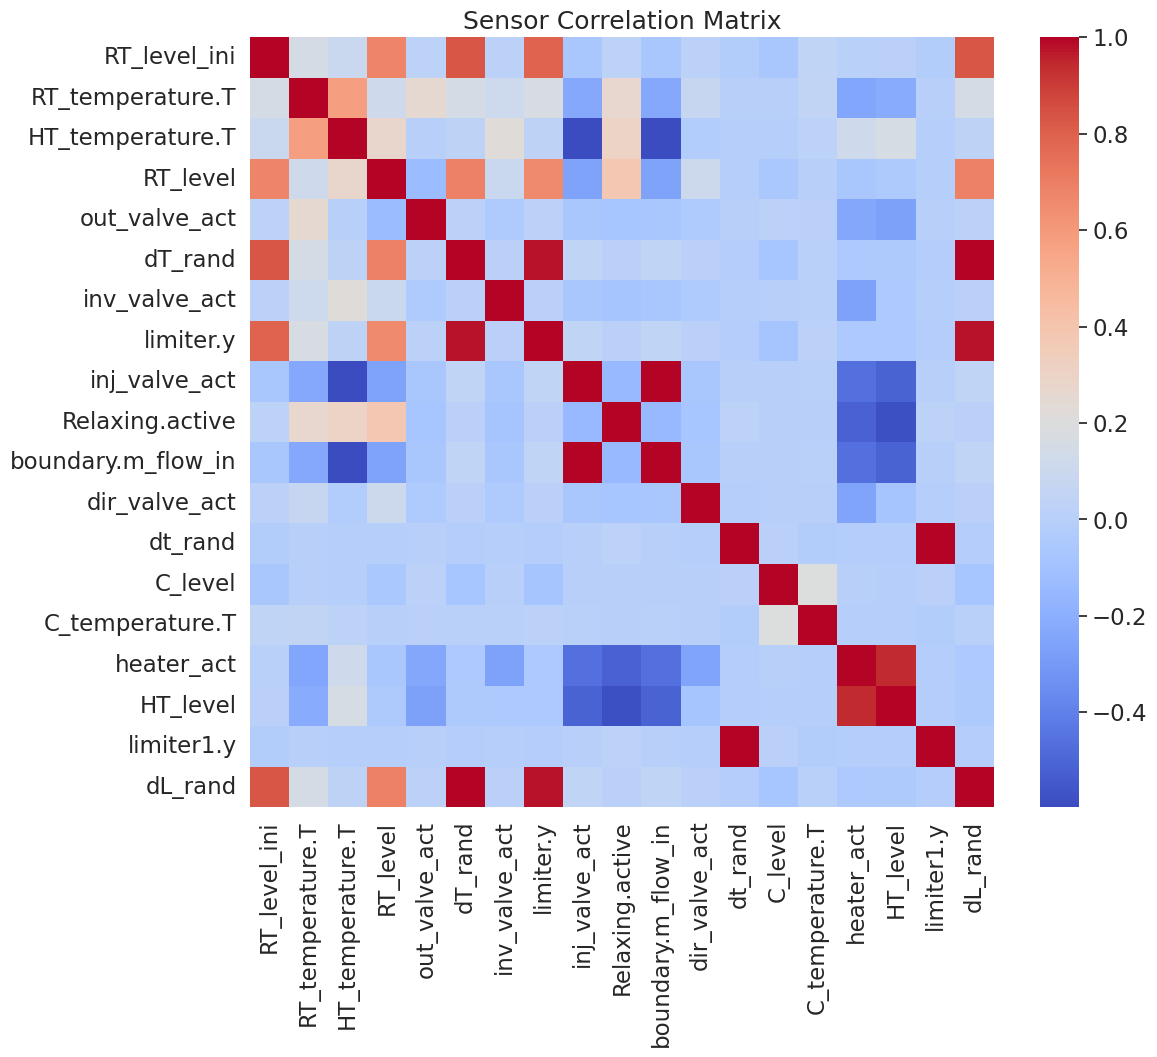

In [41]:
# Compute correlation matrix
corr_matrix = df[sensor_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Sensor Correlation Matrix')
plt.show()

In [84]:
# 🔹 Carica i dati normali
df_normal = df_1.sample(15000) 

# 🔹 Carica i dati dal file CSV
df_csv = pd.read_csv("data_2/GHL/01_Lev_fault_Temp_corr_seed_11_vars_23.csv")

# 🔹 Filtra solo le anomalie (attack == 1)
df_anomalies = df_csv[df_csv["ATTACK"] == 1]

# 🔹 Campiona un numero casuale di anomalie tra 200 e 700
df_anomalies = df_anomalies.sample(700)

# 🔹 Assicuriamoci che entrambe le tabelle abbiano le stesse feature
common_cols = list(set(df_normal.columns) & set(df_anomalies.columns))
df_normal = df_normal[common_cols]
df_anomalies = df_anomalies[common_cols]

# 🔹 Aggiungi la colonna 'attack' per indicare la classe
df_normal["ATTACK"] = 0  # Normale
df_anomalies["ATTACK"] = 1  # Anomalia

# 🔹 Unisci i dataset e mescola
df_combined = pd.concat([df_normal, df_anomalies]).sample(frac=1).reset_index(drop=True)

# 🔹 Separiamo feature e target
X = df_combined.drop(columns=["ATTACK"])  # Feature
Y = df_combined["ATTACK"]  # Target

# 🔹 Calcola la Mutual Information
mi_scores = mutual_info_classif(X, Y)

# 🔹 Crea un DataFrame con i risultati
mi_results = pd.DataFrame({"Feature": X.columns, "MI_Score": mi_scores})

# 🔹 Filtra solo le feature con MI > 0 (cioè, che portano informazione)
selected_features = mi_results[mi_results["MI_Score"] > 0].sort_values(by="MI_Score", ascending=False)
selected_features = selected_features[selected_features["Feature"].isin(["dT_rand", "HT_temperature.T"])]
# 🔹 Stampa le feature selezionate
print("Feature più informative rispetto alle anomalie:")
print(selected_features)

# 🔹 Se vuoi solo i nomi delle feature per MATLAB
important_feature_names = selected_features["Feature"].tolist()
print("\nFeature selezionate:", important_feature_names)

Feature più informative rispetto alle anomalie:
            Feature  MI_Score
0  HT_temperature.T  0.182286
2           dT_rand  0.182286

Feature selezionate: ['HT_temperature.T', 'dT_rand']


In [ ]:
# Supponiamo che `df` sia il tuo DataFrame originale
selected_features = ['dT_rand', 'HT_temperature.T']

# Creiamo un nuovo DataFrame con solo queste feature + il target
df_selected = df_combined[selected_features].copy()  # Copia solo le feature selezionate
df_selected["attack"] = Y.values
# Salviamo il file CSV
df_selected.to_csv("./data_2/relevant_features_GHS.csv", index=False)

In [91]:
df = pd.read_csv("./data_2/relevant_features_GHS.csv")


X = df.drop(columns=["attack"]).values  
y = df["attack"].values  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Numero di etichette 0 in y_test:", np.sum(y_test == 0))
print("Numero di etichette 1 in y_test:", np.sum(y_test == 1))

X_train shape: (10048, 2)
y_train shape: (10048,)
X_val shape: (2512, 2)
y_val shape: (2512,)
X_test shape: (3140, 2)
y_test shape: (3140,)
Numero di etichette 0 in y_test: 3000
Numero di etichette 1 in y_test: 140


In [ ]:
# 🔹 Salva i dataset in formato MATLAB (.mat)
sio.savemat("./data_2/fuzzy_data_GHS.mat", {
    "X_train": np.array(X_train), 
    "y_train": np.array(y_train).astype(float).reshape(-1, 1),  # Mantieni etichette in colonna
    "X_val": np.array(X_val), 
    "y_val": np.array(y_val).astype(float).reshape(-1, 1),
    "X_test_5perc": np.array(X_test), 
    "y_test_5perc": np.array(y_test).astype(float).reshape(-1, 1)
})

print("Dataset PUMP preparato e salvato in formato MATLAB!")

Dataset PUMP preparato e salvato in formato MATLAB!
